# Background
- Testing linear multi-class classifiers from course homework
- Try out multi-class softmax and multi-class perceptron cost functions
- Also play around with weighting based on number of events in each class (avoid overfitting 0 bubbles and poor fit on >0 bubbles)

In [17]:
from sys import getsizeof
from autograd import grad, hessian
from autograd.misc.flatten import flatten_func
import autograd.numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

# Cost Functions

In [2]:
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# the convex softmax cost function
def softmax(w, x, y):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost / float(np.size(y))

# the perceptron cost function
def perceptron(w, x, y):
    cost = np.sum(np.maximum(0, -y*model(x,w)))
    return cost / float(np.size(y))

# the convex softmax cost function
def weighted_softmax(w, x, y, betas):
    cost = np.sum(betas*np.log(1 + np.exp(-y*model(x,w))))
    return cost / float(np.size(y))

In [3]:
def multiclass_perceptron(w, x, y, lam=1e-5):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals, axis=0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    cost += lam*np.linalg.norm(w[1:,:])**2
    
    # return average
    return cost / float(np.size(y))

def multiclass_perceptron_weighted(w, x, y, betas, lam=1e-5):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals, axis=0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    cost = np.sum(betas*(a - b))
    
    # add regularizer
    cost += lam*np.linalg.norm(w[1:,:])**2
    
    # return average
    return cost #/ float(np.size(y))

# Descent Functions

In [4]:
def gradient_descent_class(g, alpha, max_its, w, x, y):
    """
    g: function to minimize value of
    alpha: step size
    max_its: maximum number of iterations
    w: starting weights (often randomized)
    """
    
    # create gradient calculator function for input function
    gradient = grad(g)
    
    # gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    #misclass_history = [np.sum(np.sign(model(x, w)) != y)]
    misclass_history = [np.sum(np.argmax(model(x, w), axis=0) != y)]
    for k in range(max_its):
        
        # eval gradient
        grad_eval = gradient(w)
        
        # gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
        #misclass_history.append(np.sum(np.sign(model(x, w)) != y))
        misclass_history.append(np.sum(np.argmax(model(x, w), axis=0) != y))
    
    return np.array(weight_history), np.array(cost_history), np.array(misclass_history)

In [5]:
def newtons_method_class(g, max_its, w, x, y, **kwargs):
    """
    g: function to minimize value of
    max_its: maximum number of iterations
    w: starting weights (often randomized)
    """
    
    # create gradient / hessian calculator functions for input function
    gradient = grad(g)
    hess = hessian(g)
    
    # set numerical stability parameter
    epsilon = 1e-7
    if 'epsilon' in kwargs:
        epsilon = kwargs['epsilon']
    
    # Newton's method loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    #misclass_history = [np.sum(np.sign(model(x, w)) != y)]
    misclass_history = [np.sum(np.argmax(model(x, w), axis=0) != y)]
    for k in range(max_its):
        
        # eval gradient and hessian
        grad_eval = gradient(w)
        hess_eval = hess(w)
        
        # IS THIS NECESSARY?
        # reshape hessian to square matrix
        #hess_eval.shape = (int(np.size(hess_eval)**(0.5)),int(np.size(hess_eval)**(0.5)))
        
        # solve 2nd-order system for weight update
        A = hess_eval + epsilon*np.eye(w.size)
        b = grad_eval
        w = np.linalg.solve(A, np.dot(A,w)-b)
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
        #misclass_history.append(np.sum(np.sign(model(x, w)) != y))
        misclass_history.append(np.sum(np.argmax(model(x, w), axis=0) != y))
        
    return np.array(weight_history), np.array(cost_history), np.array(misclass_history)

# Data Prep
- To format like HW datasets, we want "x" to be a 2D np.array with shape M x N where M is the number of features and N is the number of data points...and "y" is a 2D np.array with shape 1 x N containing the "N_bubs" correct classification

## Load pickle

In [7]:
df_features = pkl.load(open("FeaturesDataFrame.p", "rb"))

In [8]:
df_features

,date,run,event,bubblecount,edgefeature,blobfeature,blobpeakfeature
0,20170706,5,20170706548,-1,209.0,1.124399,0
1,20170708,6,20170708662,-1,239.0,1.093626,0
2,20170625,0,20170625027,-1,244.0,1.107351,0
3,20170925,0,20170925062,-1,259.0,1.091126,0
4,20170803,3,20170803337,-1,250.0,1.119024,0
...,...,...,...,...,...,...,...
24552,20170926,2,20170926216,1,278.0,1.199092,2
24553,20171010,3,20171010376,-1,239.0,1.115799,0
24554,20170715,1,2017071514,-1,250.0,1.138690,0
24555,20170929,3,20170929313,-1,264.0,1.122245,0


In [9]:
# remove -1 with blobpeaks
df_features = df_features.query('not (bubblecount == -1 & blobpeakfeature > 1)').copy()
df_features.reset_index(drop=True, inplace=True)

In [10]:
df_features

,date,run,event,bubblecount,edgefeature,blobfeature,blobpeakfeature
0,20170706,5,20170706548,-1,209.0,1.124399,0
1,20170708,6,20170708662,-1,239.0,1.093626,0
2,20170625,0,20170625027,-1,244.0,1.107351,0
3,20170925,0,20170925062,-1,259.0,1.091126,0
4,20170803,3,20170803337,-1,250.0,1.119024,0
...,...,...,...,...,...,...,...
23329,20170926,2,20170926216,1,278.0,1.199092,2
23330,20171010,3,20171010376,-1,239.0,1.115799,0
23331,20170715,1,2017071514,-1,250.0,1.138690,0
23332,20170929,3,20170929313,-1,264.0,1.122245,0


In [11]:
df_features.loc[df_features.bubblecount == -1, 'bubblecount'] = 0

In [12]:
df_features

,date,run,event,bubblecount,edgefeature,blobfeature,blobpeakfeature
0,20170706,5,20170706548,0,209.0,1.124399,0
1,20170708,6,20170708662,0,239.0,1.093626,0
2,20170625,0,20170625027,0,244.0,1.107351,0
3,20170925,0,20170925062,0,259.0,1.091126,0
4,20170803,3,20170803337,0,250.0,1.119024,0
...,...,...,...,...,...,...,...
23329,20170926,2,20170926216,1,278.0,1.199092,2
23330,20171010,3,20171010376,0,239.0,1.115799,0
23331,20170715,1,2017071514,0,250.0,1.138690,0
23332,20170929,3,20170929313,0,264.0,1.122245,0


In [13]:
x = df_features[['edgefeature', 'blobfeature', 'blobpeakfeature']].values.T

In [14]:
x.shape

(3, 23334)

In [15]:
y = df_features['bubblecount'].values[np.newaxis, :]

In [16]:
y.shape

(1, 23334)

- Now our feature data is in the correct form.

In [21]:
x.size * x.itemsize / 1000 / 1000 # MB

0.560016

In [22]:
y.size * y.itemsize / 1000 / 1000 # MB

0.186672

## Normalize Data (???)
- If feature values are wildly different, we should normalize the data before classifying

In [23]:
mus = np.mean(x, axis=1).reshape(1,-1)
stds = ((np.mean((x - mus.T)**2, axis=1))**(1/2)).reshape(1, -1)
x_normed = (x - mus.T)/ stds.T

In [24]:
x

array([[209.        , 239.        , 244.        , ..., 250.        ,
        264.        , 272.        ],
       [  1.1243992 ,   1.09362589,   1.1073513 , ...,   1.1386899 ,
          1.12224511,   1.13223875],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [25]:
x_normed

array([[-1.58332163, -0.81790246, -0.6903326 , ..., -0.53724877,
        -0.18005315,  0.02405862],
       [-0.42586251, -0.54017483, -0.48918964, ..., -0.37277748,
        -0.43386425, -0.39674127],
       [-0.67698801, -0.67698801, -0.67698801, ..., -0.67698801,
        -0.67698801, -0.67698801]])

# Multiclass Perceptron

In [27]:
# weights
betas = np.ones(x.shape[1])
n0 = np.sum(y == 0)
n1 = np.sum(y == 1)
n2 = np.sum(y == 2)
n3 = np.sum(y == 3)
n4 = np.sum(y == 4)
n_dict = {0:n0, 1:n1, 2:n2, 3:n3, 4:n4}
betas = np.array([1./n_dict[y_] for y_ in y.flatten()])
#betas = np.array([1./(2*n_dict[y_]) for y_ in y.flatten()])

In [28]:
def g_mc_percept(w):
    #return multiclass_perceptron(w, x_normed, y)
    return multiclass_perceptron_weighted(w, x_normed, y, betas, lam=1e-5)

In [29]:
betas

array([6.22858922e-05, 6.22858922e-05, 6.22858922e-05, ...,
       6.22858922e-05, 6.22858922e-05, 6.22858922e-05])

In [30]:
w0 = np.random.rand(x.shape[0]+1, x.shape[1])

In [31]:
w0.shape

(4, 23334)

In [32]:
g_mc_percept(w0)

15.414512337430141

In [561]:
### HESSIAN STUFF ### 

In [476]:
# flatten an input function g
g_flat, unflatten_func, w = flatten_func(g_mc_percept, w0)

In [478]:
g_flat(w0)

array([5.79894589])

In [480]:
hess = hessian(g_flat)

In [481]:
hess_eval = hess(w0)

In [482]:
hess_eval.shape

(1, 4, 2783, 4, 2783)

In [465]:
hess = hessian(g_mc_percept)

In [467]:
hess_eval = hess(w0)

In [469]:
hess_eval.shape

(4, 2783, 4, 2783)

In [471]:
type(g_mc_percept(w0))

numpy.float64

In [468]:
hess_eval

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.000000

In [562]:
###

In [44]:
alpha = 0.1
its = 100#200
wh, ch, mch = gradient_descent_class(g_mc_percept, alpha=alpha, max_its=its, w=w0, x=x_normed, y=y)
#wh, ch, mch = newtons_method_class(g_mc_percept, max_its=its, w=w0, x=x, y=y)

In [45]:
it_num = np.arange(0, its+1)

In [46]:
output_dict = {'iteration': it_num, 'weights': wh, 'costs': ch, 'misclasses': mch}

In [48]:
# save results
pkl.dump(output_dict, open('MultiClassPerceptronResults.p','wb'))

Text(0.5, 1.0, 'Multiclass Perceptron For Bubble Dataset')

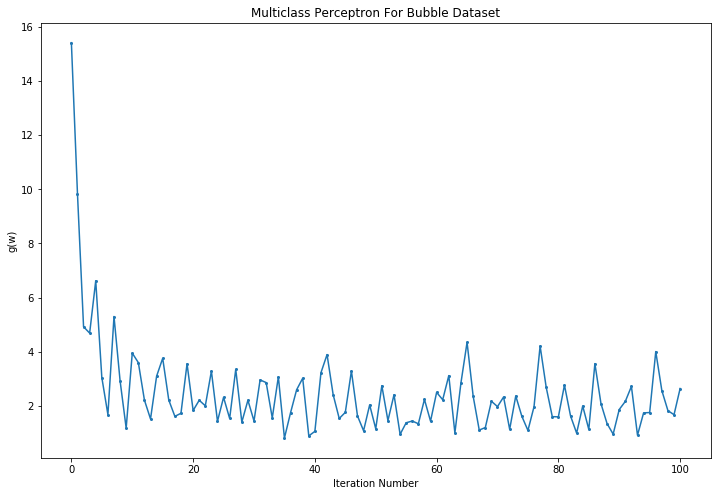

In [49]:
#for y_, c_ in zip(y_un, cs):
plt.plot(it_num, ch, marker='o', markersize=2,) #label=f"'one' label: {int(y_):1d}")
plt.xlabel("Iteration Number")
plt.ylabel(r'g(w)')
plt.title('Multiclass Perceptron For Bubble Dataset')
#plt.yscale('log')
#plt.legend();

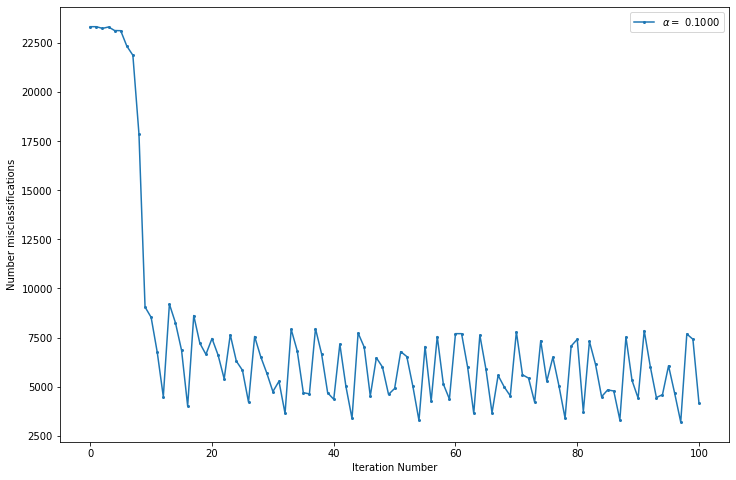

In [50]:
plt.plot(it_num, mch, marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel("Number misclassifications")
#plt.yscale('log')
plt.legend();

In [51]:
mch.min()

3197

In [52]:
mch.min() / len(df_features)

0.13701037113225337

In [53]:
1 - mch.min() / len(df_features)

0.8629896288677467

In [54]:
mch[0] / len(df_features)

1.0

In [413]:
w = wh[-1]

In [414]:
model_eval = np.argmax(model(x_normed, w), axis=0)[np.newaxis, :]

In [415]:
model_eval[y==0]

array([1, 0, 1, ..., 1, 0, 0])

In [416]:
corrects = model_eval == y

In [417]:
np.sum(corrects[y==0]), np.sum(corrects[y==1]), np.sum(corrects[y==2])

(954, 381, 21)

In [418]:
np.sum(corrects[y==0])/(y==0).sum(), np.sum(corrects[y==1])/(y==1).sum(), np.sum(corrects[y==2])/(y==2).sum()

(0.4840182648401826, 0.4841168996188056, 0.84)

In [419]:
len(y[y==0])

1971

In [420]:
y[y==2].sum()

50

In [421]:
model_eval

array([[1, 0, 1, ..., 0, 0, 2]])

In [422]:
y

array([[0, 0, 0, ..., 0, 0, 1]])

In [423]:
N_correct = (model_eval == y).sum()

In [424]:
N_correct

1356

In [425]:
N_misclassified = y.size - N_correct

In [426]:
N_misclassified

1427

In [427]:
N_correct / y.size

0.4872439813151276

In [428]:
mch

array([5697619, 5697558, 5697508, 5697474, 5697455, 5697440, 5697434,
       5697427, 5697423, 5697416, 5697407, 5697402, 5697394, 5697392,
       5697385, 5697379, 5697375, 5697371, 5697366, 5697357, 5697353,
       5697349, 5697348, 5697343, 5697343, 5697339, 5697339, 5697335,
       5697334, 5697333, 5697330, 5697329, 5697328, 5697329, 5697328,
       5697327, 5697322, 5697322, 5697322, 5697322, 5697319, 5697319,
       5697319, 5697319, 5697317, 5697317, 5697311, 5697311, 5697310,
       5697310, 5697308, 5697308, 5697304, 5697304, 5697304, 5697303,
       5697303, 5697303, 5697303, 5697303, 5697301, 5697301, 5697301,
       5697295, 5697295, 5697295, 5697295, 5697295, 5697295, 5697294,
       5697294, 5697294, 5697293, 5697293, 5697293, 5697292, 5697292,
       5697291, 5697291, 5697291, 5697290, 5697288, 5697288, 5697288,
       5697288, 5697288, 5697288, 5697288, 5697288, 5697287, 5697287,
       5697286, 5697285, 5697285, 5697285, 5697285, 5697285, 5697284,
       5697284, 5697

In [429]:
mch_true = []
for w in wh:
    model_eval = np.argmax(model(x_normed, w), axis=0)[np.newaxis, :]
    N_correct = (model_eval == y).sum()
    N_misclassified = y.size - N_correct
    mch_true.append(N_misclassified)
mch_true = np.array(mch_true)

In [430]:
mch_true

array([2783, 2783, 2652, 2468, 2438, 2419, 2384, 2394, 2383, 2259, 1791,
       1519, 1337, 1246, 1230, 1150, 1193, 1083, 1212, 1022, 1230, 1020,
       1154,  978, 1163,  969, 1150,  944, 1146,  918, 1137,  900, 1094,
        860, 1101,  852, 1110,  831, 1043,  795, 1104,  822,  908,  765,
       1059,  761, 1150,  870,  846,  764, 1088,  773, 1283,  968,  686,
       1215,  893,  764,  935,  707, 1458, 1028,  662, 1463,  940,  655,
       1467,  904,  603, 1625,  866,  699, 1421,  876,  583, 1580,  739,
        683, 1331,  915,  594, 1244,  569, 1862,  901,  973, 1187, 1598,
        498, 1510,  757,  651, 1569,  821,  822, 1359, 1280,  443, 2064,
        861,  713, 1502, 1020,  704, 1314, 1281,  536, 1485,  717,  583,
       1428,  447, 2186,  909,  636, 1650,  884, 1844,  955,  888, 1358,
        977, 1265,  438, 2046,  746,  624, 1413,  903,  453, 2220,  861,
        523, 1913,  896, 1288,  976, 1415,  419, 2126,  815,  569, 1753,
        857, 1804,  951,  806, 1316,  970, 1117,  4

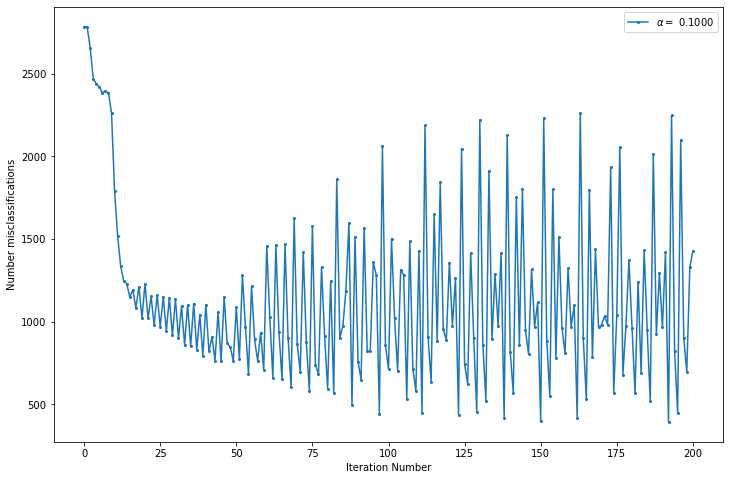

In [431]:
#for alpha in alphas:
plt.plot(it_num, mch_true, marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel("Number misclassifications")
#plt.yscale('log')
plt.legend();

In [432]:
mch_true.min()

394

In [433]:
mch_true.min() / y.size

0.14157384117858426

In [445]:
mch_true[0] / y.size

1.0

In [447]:
mch_true[0]

2783

In [450]:
y.size

2783

In [434]:
i_best = mch_true.argmin()
i_best

192

In [435]:
wh[i_best]

array([[1.84352362, 1.87132669, 1.63009175, ..., 0.60565837, 0.0756275 ,
        0.63014402],
       [0.59782167, 0.58391048, 0.74851283, ..., 0.29787477, 0.74113714,
        0.04858272],
       [0.73780093, 0.93937842, 0.82285071, ..., 0.00378158, 0.51610025,
        0.30640527],
       [0.03358072, 0.06517551, 0.25449868, ..., 0.33345182, 0.84101042,
        0.47900659]])

In [436]:
ch[i_best]

0.20084169549174274

In [451]:
wh[i_best]

array([[1.84352362, 1.87132669, 1.63009175, ..., 0.60565837, 0.0756275 ,
        0.63014402],
       [0.59782167, 0.58391048, 0.74851283, ..., 0.29787477, 0.74113714,
        0.04858272],
       [0.73780093, 0.93937842, 0.82285071, ..., 0.00378158, 0.51610025,
        0.30640527],
       [0.03358072, 0.06517551, 0.25449868, ..., 0.33345182, 0.84101042,
        0.47900659]])

In [437]:
w = wh[i_best]

In [438]:
model_eval = np.argmax(model(x_normed, w), axis=0)[np.newaxis, :]

In [439]:
model_eval[y==0]

array([0, 0, 0, ..., 0, 0, 0])

In [440]:
corrects = model_eval == y

In [441]:
np.sum(corrects[y==0]), np.sum(corrects[y==1]), np.sum(corrects[y==2])

(1767, 618, 4)

In [442]:
np.sum(corrects[y==0])/(y==0).sum(), np.sum(corrects[y==1])/(y==1).sum(), np.sum(corrects[y==2])/(y==2).sum()

(0.8964992389649924, 0.7852604828462516, 0.16)

In [443]:
y.size

2783

# Softmax

In [83]:
def g_softmax(w):
    # return softmax(w, x, y) # not normalized
    return softmax(w, x_normed, y) # normalized
    
    #return softmax(w, x_normed, y) # normalized + weighted

In [103]:
w0 = np.random.rand(x.shape[0]+1)

In [104]:
w0

array([0.93859259, 0.68566871, 0.97221117, 0.51978734])

In [105]:
g_softmax(w0)

0.5513611413353109

In [106]:
#alphas = [2e-1, 1e-1, 1e-2]
#its = 3000

In [108]:
its = 200

In [109]:
wh_dict = {f"{alpha:.4f}":[] for alpha in alphas}
ch_dict = {f"{alpha:.4f}":[] for alpha in alphas}
mc_dict = {f"{alpha:.4f}":[] for alpha in alphas}

In [110]:
for alpha in alphas:
    #wh, ch, mc = gradient_descent_class(g_softmax, alpha=alpha, max_its=its, w=w0, x=x_normed, y=y)
    wh, ch, mc = newtons_method_class(g_softmax, max_its=its, w=w0, x=x_normed, y=y)
    wh_dict[f"{alpha:.4f}"] = wh
    ch_dict[f"{alpha:.4f}"] = ch
    mc_dict[f"{alpha:.4f}"] = mc

In [111]:
it_num = np.arange(0, its+1)

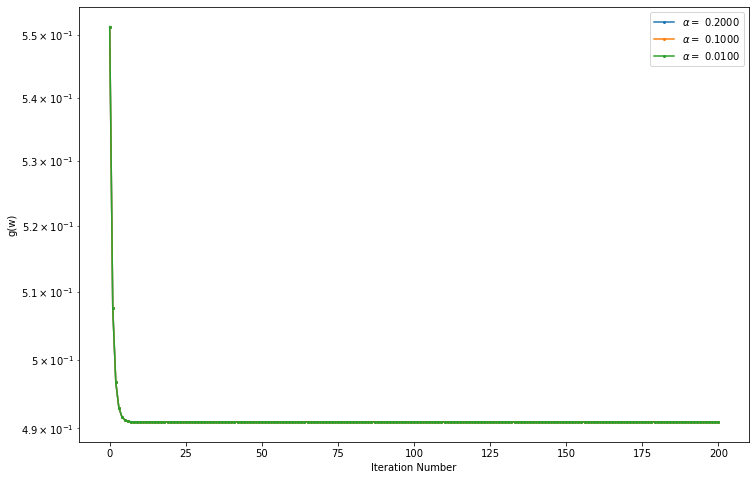

In [112]:
for alpha in alphas:
    plt.plot(it_num, ch_dict[f"{alpha:.4f}"], marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel(r'g(w)')
plt.yscale('log')
plt.legend();

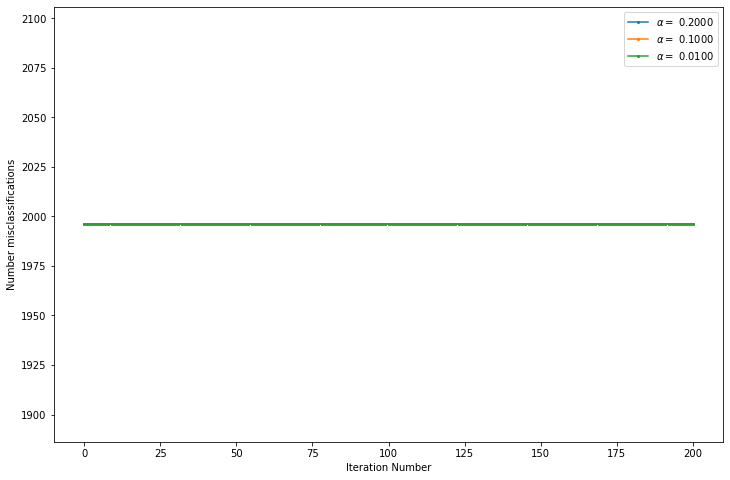

In [113]:
for alpha in alphas:
    plt.plot(it_num, mc_dict[f"{alpha:.4f}"], marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel("Number misclassifications")
#plt.yscale('log')
plt.legend();

In [102]:
len(df_features)

2783

# Weighted Softmax
- Weight by number of events in each class

In [83]:
#def g_softmax(w):
    # return softmax(w, x, y) # not normalized
    #return softmax(w, x_normed, y) # normalized
    
    #return softmax(w, x_normed, y) # normalized + weighted

In [114]:
w0 = np.random.rand(x.shape[0]+1)

In [115]:
w0

array([0.49980159, 0.93060847, 0.25354502, 0.48650005])

In [119]:
betas = np.ones(x.shape[1])

In [124]:
n0 = np.sum(y == 0)
n1 = np.sum(y == 1)
n2 = np.sum(y == 2)
n3 = np.sum(y == 3)
n4 = np.sum(y == 4)

In [125]:
n0, n1, n2, n3, n4

(1971, 787, 25, 0, 0)

In [126]:
n_dict = {0:n0, 1:n1, 2:n2}

In [128]:
n_dict[0]

1971

In [131]:
y.flatten()

array([0, 0, 0, ..., 0, 0, 1])

In [132]:
betas = np.array([1./n_dict[y_] for y_ in y.flatten()])

In [133]:
betas

array([0.00050736, 0.00050736, 0.00050736, ..., 0.00050736, 0.00050736,
       0.00127065])

In [173]:
w0 = np.random.rand(x.shape[0]+1)

In [174]:
weighted_softmax(w0, x_normed, y, betas)

0.0004026272381960501

In [172]:
betas

array([0.00050736, 0.00050736, 0.00050736, ..., 0.00050736, 0.00050736,
       0.00127065])

In [175]:
def g_soft_weighted(w):
    return weighted_softmax(w, x_normed, y, betas)

In [176]:
g_soft_weighted(w0)

0.0004026272381960501

In [106]:
#alphas = [2e-1, 1e-1, 1e-2]
#its = 3000

In [177]:
its = 200

In [178]:
wh_dict = {f"{alpha:.4f}":[] for alpha in alphas}
ch_dict = {f"{alpha:.4f}":[] for alpha in alphas}
mc_dict = {f"{alpha:.4f}":[] for alpha in alphas}

In [179]:
for alpha in alphas:
    #wh, ch, mc = gradient_descent_class(g_softmax, alpha=alpha, max_its=its, w=w0, x=x_normed, y=y)
    wh, ch, mc = newtons_method_class(g_soft_weighted, max_its=its, w=w0, x=x_normed, y=y)
    wh_dict[f"{alpha:.4f}"] = wh
    ch_dict[f"{alpha:.4f}"] = ch
    mc_dict[f"{alpha:.4f}"] = mc

In [180]:
it_num = np.arange(0, its+1)

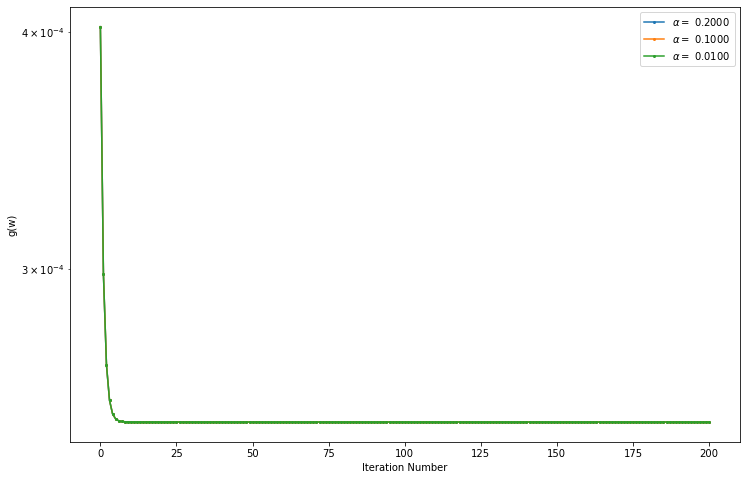

In [181]:
for alpha in alphas:
    plt.plot(it_num, ch_dict[f"{alpha:.4f}"], marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel(r'g(w)')
plt.yscale('log')
plt.legend();

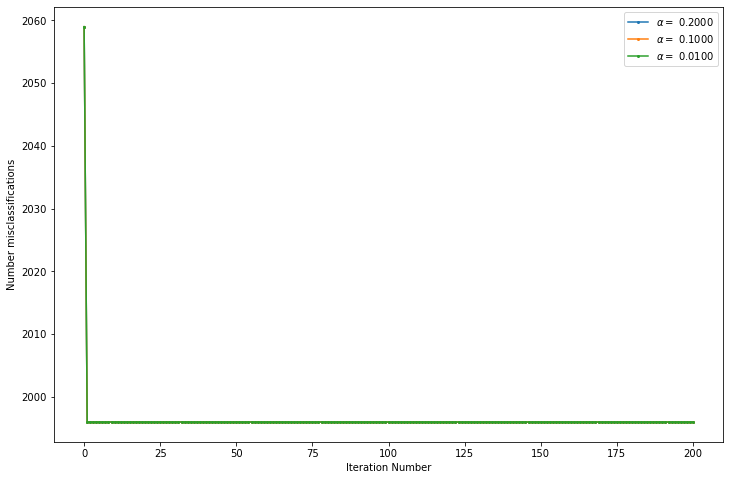

In [182]:
for alpha in alphas:
    plt.plot(it_num, mc_dict[f"{alpha:.4f}"], marker='o', markersize=2, label=r"$\alpha =$"+f" {alpha:.4f}")
plt.xlabel("Iteration Number")
plt.ylabel("Number misclassifications")
#plt.yscale('log')
plt.legend();

In [183]:
len(df_features)

2783